<a href="https://colab.research.google.com/github/temple17/hands-on-ml-practice/blob/main/Chapter3_classification_2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the data

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

X.shape
y.shape

(70000,)

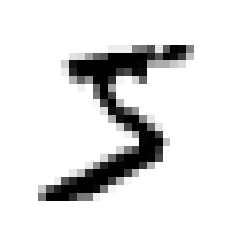

In [3]:
# all you need to do is grab an instance's feature vector, reshape it to a 28X28 array
import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
# the label is a string. so let's cast y to integer
import numpy as np
import pandas as pd
y = y.astype(np.uint8)

# Train set and test set

In [6]:
# The MNIST dataset is actually already split into a training set (the first 60,000 images)    
# and a test set (the last 10,000 images)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# the training set is already shuffled for us, which is good because this gurantees that  
# all cross-validation folds will be similar

# Training a Binary Classifier

In [7]:
# 5 and not-5

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# start with SGD
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [8]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measure

## Measuring Accuracy Using Cross-Validation

In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clf, X_train, y_train_5,
                         scoring = 'accuracy', cv = 3)

In [10]:
scores

array([0.965  , 0.96495, 0.9577 ])

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X,y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

In [13]:
"""
This is simply because only about 10% of the images are 5s, so if you always
guess that an image is not a 5, you will ber right about 90% of the time.
This demonstrates why accuracy is generally not the preferred performance measure
for classifiers
"""

'\nThis is simply because only about 10% of the images are 5s, so if you always\nguess that an image is not a 5, you will ber right about 90% of the time.\nThis demonstrates why accuracy is generally not the preferred performance measure\nfor classifiers\n'

## Confusion-matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv =3)

Just like the cross_val_score() function, cross_val_predict() performs    
K-fold cross_validation, but instead of returning the evaluation scores, it    
returns the predictions made on each test fold.

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54326,   253],
       [ 2229,  3192]])

## Precision and Recall

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.9265602322206096

In [17]:
recall_score(y_train_5, y_train_pred)

0.5888212506917543

In [18]:
# combine recall and precision = > f1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.720054139408978

In [19]:
y_scores = sgd_clf.decision_function([some_digit])

In [20]:
y_scores

array([1962.07734199])

In [21]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshhold = 8000
y_some_digit_pred = (y_scores > threshhold)
y_some_digit_pred

array([False])

### How do you decied which threshold to use
1. use the cross_val_predict() function to get the scores of all instances    
in the training set, but this time specify that you want  to return decision scores instead of predictions

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [25]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")

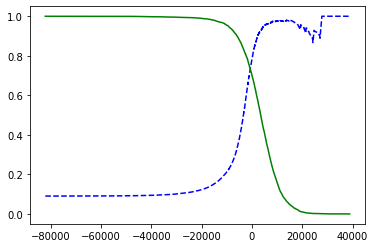

In [26]:
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)


In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [28]:
threshold_90_precision

2266.9272515092903

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000287273771904

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.5779376498800959

## ROC Curve(Reciver operating characteristics curve

In [33]:
# TP vs FPR

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

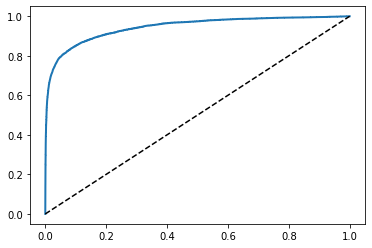

In [35]:
plot_roc_curve(fpr, tpr)

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9439449712908515

# RandomForestClassifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method ='predict_proba')

In [38]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

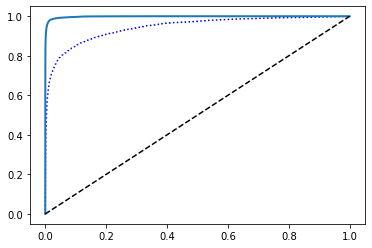

In [39]:
plt.plot(fpr, tpr, 'b:', label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")


In [40]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

### Summary
1. train binary classifier
2. choose appropriate metric
3. evaluate using cross_validation
4. precision/recall trade-off
5. ROC curve ROC AUC scores

# Multiclass Classification

- SGD classifiers, Random Forest classifiers, and naive Bayes classifiers   
=> are capable of handling multiple classes natively
- Logistic Regression, Support Vector Machine classifiers are strictly binary classifiers.

## OvR(one-versus-the-rest) , OvO(one-versus-one)
=> for most binary classification algorithms, OvR is preferred

## SVM

In [41]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [46]:
np.argmax(some_digit_scores)

5

In [47]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
# from sklearn.multiclass import OneVsRestClassifier

# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)
# ovr_clf.predict([some_digit])

In [51]:
# len(ovr_clf.estimators_)

In [52]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [53]:
sgd_clf.decision_function([some_digit])

array([[-22543.11068596, -29324.05554408,  -5515.61725337,
           801.36503655, -24642.4432637 ,    540.80156865,
        -21581.32016084, -17078.5072644 ,  -8172.45634877,
        -12420.02277882]])

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.8558, 0.8522, 0.8632])

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8981, 0.8924, 0.8981])

# Error Analysis

In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5578,    0,   23,    6,    9,   50,   36,    6,  214,    1],
       [   0, 6408,   38,   24,    4,   45,    4,    8,  198,   13],
       [  27,   27, 5233,   91,   72,   25,   69,   38,  368,    8],
       [  23,   18,  116, 5233,    2,  210,   27,   40,  389,   73],
       [  11,   14,   47,    9, 5196,   11,   35,   27,  324,  168],
       [  27,   15,   28,  168,   54, 4465,   77,   16,  508,   63],
       [  30,   15,   41,    3,   42,   99, 5558,    3,  126,    1],
       [  19,   10,   52,   32,   49,   13,    3, 5696,  178,  213],
       [  17,   68,   46,   91,    3,  129,   25,   10, 5419,   43],
       [  23,   18,   31,   66,  116,   37,    1,  178,  352, 5127]])

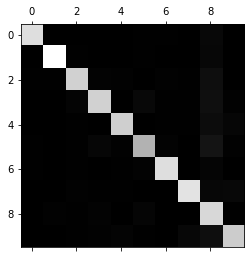

In [57]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()